# Multivariate LSTM model
This script contains the multivariate LSTM model that is used in the code for OpenRemote. This script is based on the optimized LSTM model from Mark but the hour of the day and day of the week are extracted from the timestamp to put into the model, so the model also will take this information with it for the forecast. 

                      value  HourOfDay  DayOfWeek
timestamp                                        
2022-02-02 00:00:00  95.775          0          2
2022-02-02 00:30:00  85.695          0          2
2022-02-02 01:00:00  73.517          1          2
2022-02-02 01:30:00  60.896          1          2
2022-02-02 02:00:00  50.675          2          2


<AxesSubplot:xlabel='timestamp'>

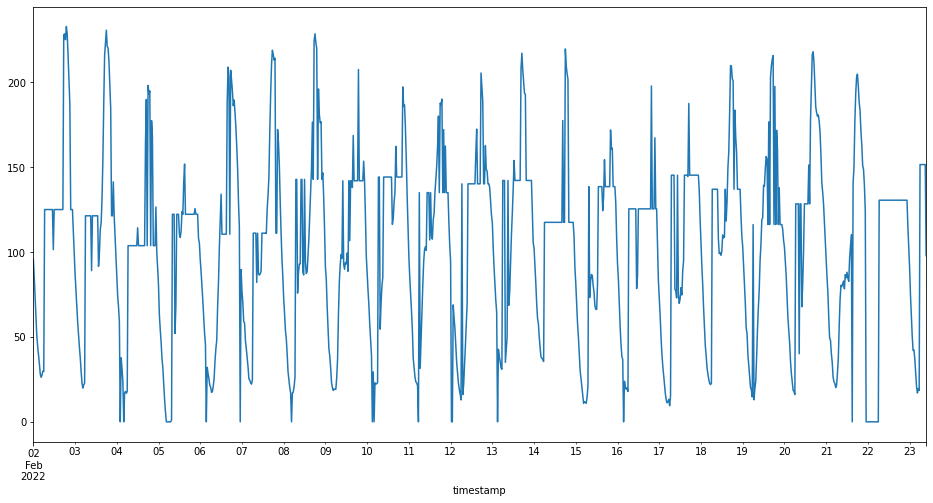

In [10]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

#PREPARING/CLEANING DATASET
# load data
df = pd.read_json('laadpalen.json')

##change timestamp data type to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

##take ony the timestamp and value
df = df[['timestamp', 'value']]

##sorting the values based on timestamps
df.sort_values(by=['timestamp'], inplace=True)

# mark all NA values with 0
df['value'].fillna(0, inplace=True)

# resample the data to intervals of 30 minutes
df2 = df.set_index('timestamp').resample('30min').agg("first").interpolate(method='linear')
df = df.set_index('timestamp').resample('30min').agg("first").fillna(0)

plt.figure(figsize = (16,8))
# drop the first 2 rows to start te dataset at 00:00
df = df[2:]
# get hours and dayofweek in columns (dayofweek monday = 0 and sunday = 6)
df['HourOfDay'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
# summarize first 5 rows
print(df.head(5))
# save to file
df.to_csv('Laadpalen_Clean.csv')

df['value'].plot()


<AxesSubplot:xlabel='timestamp'>

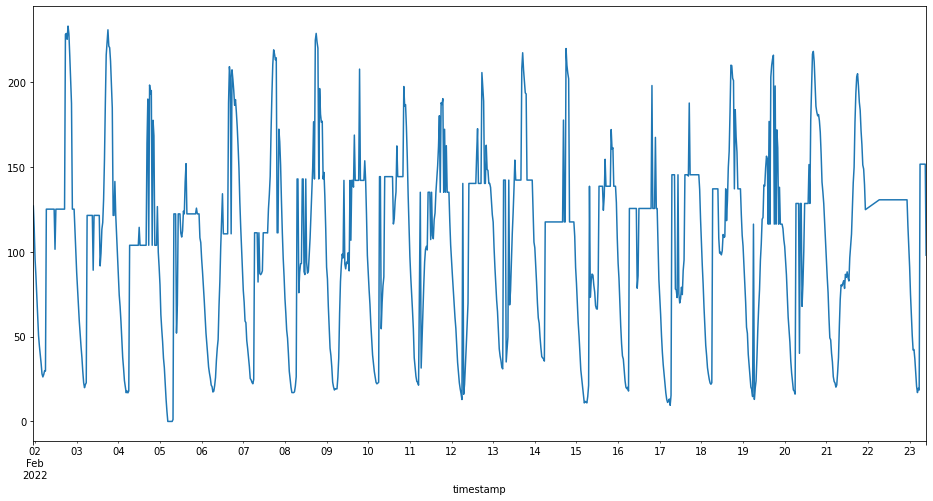

In [11]:
plt.figure(figsize = (16,8))
df2['value'].plot()


In [12]:
# prepare data for lstm
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
	
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()

	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
values = df.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[4, 5]], axis=1, inplace=True)
print(reframed.tail(50))

      var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
978    0.560607   0.347826   0.166667  0.560607
979    0.560607   0.391304   0.166667  0.560607
980    0.560607   0.391304   0.166667  0.560607
981    0.560607   0.434783   0.166667  0.560607
982    0.560607   0.434783   0.166667  0.560607
983    0.560607   0.478261   0.166667  0.560607
984    0.560607   0.478261   0.166667  0.560607
985    0.560607   0.521739   0.166667  0.560607
986    0.560607   0.521739   0.166667  0.560607
987    0.560607   0.565217   0.166667  0.560607
988    0.560607   0.565217   0.166667  0.560607
989    0.560607   0.608696   0.166667  0.560607
990    0.560607   0.608696   0.166667  0.560607
991    0.560607   0.652174   0.166667  0.560607
992    0.560607   0.652174   0.166667  0.560607
993    0.560607   0.695652   0.166667  0.560607
994    0.560607   0.695652   0.166667  0.560607
995    0.560607   0.739130   0.166667  0.560607
996    0.560607   0.739130   0.166667  0.560607
997    0.560607   0.782609   0.166667  0

In [13]:
# split into train and test sets
values = reframed.values
n_train_half_hours = 14 * 48
train = values[:n_train_half_hours, :]
test = values[n_train_half_hours:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

    
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(672, 1, 3) (672,) (355, 1, 3) (355,)


Epoch 1/50
10/10 - 2s - loss: 0.4116 - val_loss: 0.3786 - 2s/epoch - 194ms/step
Epoch 2/50
10/10 - 0s - loss: 0.3729 - val_loss: 0.3424 - 48ms/epoch - 5ms/step
Epoch 3/50
10/10 - 0s - loss: 0.3350 - val_loss: 0.3076 - 64ms/epoch - 6ms/step
Epoch 4/50
10/10 - 0s - loss: 0.2979 - val_loss: 0.2717 - 58ms/epoch - 6ms/step
Epoch 5/50
10/10 - 0s - loss: 0.2591 - val_loss: 0.2332 - 72ms/epoch - 7ms/step
Epoch 6/50
10/10 - 0s - loss: 0.2176 - val_loss: 0.1917 - 54ms/epoch - 5ms/step
Epoch 7/50
10/10 - 0s - loss: 0.1741 - val_loss: 0.1559 - 77ms/epoch - 8ms/step
Epoch 8/50
10/10 - 0s - loss: 0.1423 - val_loss: 0.1399 - 84ms/epoch - 8ms/step
Epoch 9/50
10/10 - 0s - loss: 0.1368 - val_loss: 0.1356 - 68ms/epoch - 7ms/step
Epoch 10/50
10/10 - 0s - loss: 0.1349 - val_loss: 0.1321 - 61ms/epoch - 6ms/step
Epoch 11/50
10/10 - 0s - loss: 0.1308 - val_loss: 0.1285 - 60ms/epoch - 6ms/step
Epoch 12/50
10/10 - 0s - loss: 0.1261 - val_loss: 0.1253 - 52ms/epoch - 5ms/step
Epoch 13/50
10/10 - 0s - loss: 0.1220

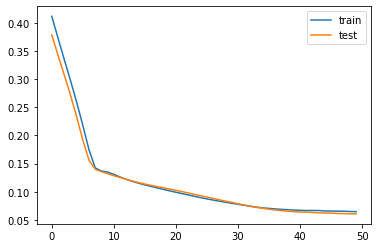

In [14]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(50, activation='relu',input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [15]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 28.490


C:\Users\jerry\AppData\Local\Temp/ipykernel_1672/1331659426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_LSTM['Predictions'] = inv_yhat


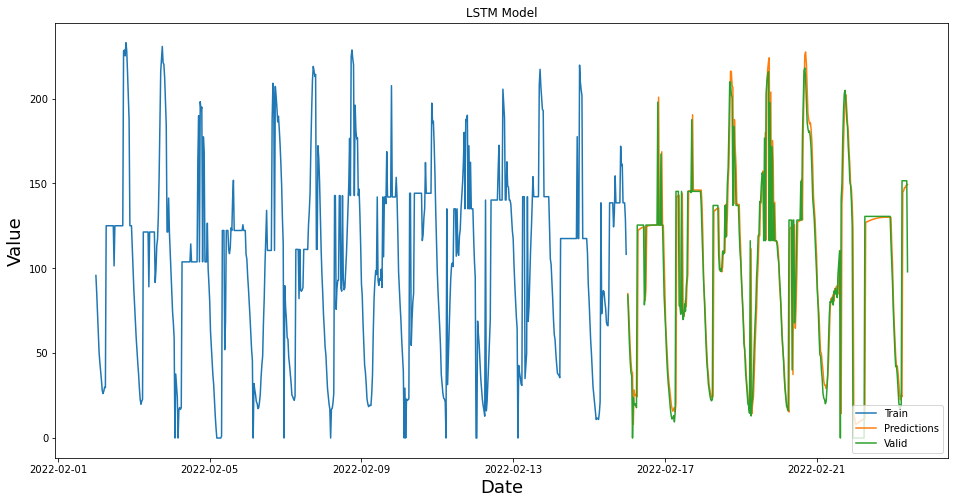

In [16]:
import matplotlib.pyplot as plt

#put the data into different training and validation dataframe and add predictions to validation dataframe
train_LSTM = df[:n_train_half_hours]
valid_LSTM = df[n_train_half_hours+1:]
valid_LSTM['Predictions'] = inv_yhat

#visualize data
plt.figure(figsize = (16,8))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.plot(train_LSTM['value'])
plt.plot(valid_LSTM['Predictions'])
plt.plot(valid_LSTM['value'])
plt.legend(['Train','Predictions', 'Valid'], loc='lower right')
plt.show()

In [19]:
# Calculate RMSE percentage
min = df['value'].min()
max = df['value'].max()
print(rmse / (max-min) * 100)

12.230361597954072


In [18]:
# Put the data into a JSON format
train_LSTM.to_json('training_data.json', orient='records')
valid_LSTM.to_json('forecast_data.json', orient='records')